In [14]:
import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [17]:
# Real과 Fake를 구분하는 Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0,1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    def forward(self ,x ):
        return self.disc(x)

In [18]:
# 이미지 생성모델 
# z_dim이라는 노이즈를 받고 output_size로 이미지 사이즈를 받음 여기선 28x28x1
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim,256),
            nn.LeakyReLU(0,1),
            nn.Linear(256, img_dim),
            nn.Tanh(),
        )
    def forward(self ,x):
        return self.gen(x)

In [19]:
# hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 10 # 128, 256
image_dim = 28 * 28 * 1 # 784
batch_size = 32
num_epochs = 50

In [20]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [21]:
transforms = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),]
)

In [22]:
dataset = datasets.MNIST(root='./Desktop', transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

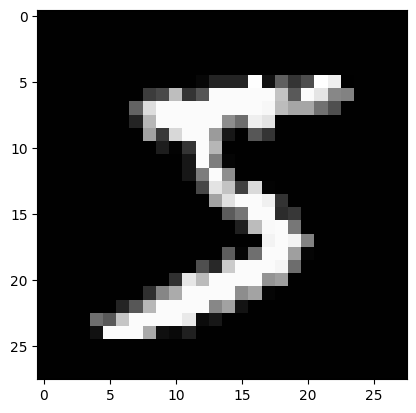

In [23]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
img, label = dataset[0]
plt.imshow(to_pil_image(img),cmap='gray')

In [24]:
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real= SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [ ]:
for epoch in range(3000):
    for batch_idx, (real,_) in enumerate(loader):
        real = real.view(-1,784).to(device)
        batch_size = real.shape[0]
      
        # noise 배치 x z_dim 
        noise = torch.randn(batch_size,z_dim).to(device)
        fake = gen(noise)
        # 진짜 이미지는 1로 학습시킴 
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real+lossD_fake)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        # output으로 니온 fake 이미지를 1에 맞출 수 있게 gen의 가중치를 맞춰줌 
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )
        with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images2", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images2", img_grid_real, global_step=step
                )
                step += 1 

Epoch [0/50] Batch 0/1875                       Loss D: 0.7414, loss G: 0.6619
Epoch [1/50] Batch 0/1875                       Loss D: 0.4758, loss G: 1.0929
Epoch [2/50] Batch 0/1875                       Loss D: 0.2837, loss G: 1.5138
Epoch [3/50] Batch 0/1875                       Loss D: 0.2076, loss G: 1.8483
Epoch [4/50] Batch 0/1875                       Loss D: 0.6448, loss G: 0.9960
Epoch [5/50] Batch 0/1875                       Loss D: 0.3977, loss G: 1.1637
Epoch [6/50] Batch 0/1875                       Loss D: 0.5750, loss G: 1.2245
Epoch [7/50] Batch 0/1875                       Loss D: 0.7785, loss G: 0.8678
Epoch [8/50] Batch 0/1875                       Loss D: 0.5723, loss G: 0.9407
Epoch [9/50] Batch 0/1875                       Loss D: 0.7452, loss G: 0.7082
Epoch [10/50] Batch 0/1875                       Loss D: 0.8858, loss G: 0.9244
Epoch [11/50] Batch 0/1875                       Loss D: 0.6992, loss G: 0.7453
Epoch [12/50] Batch 0/1875                       L

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\db\.conda\envs\3.7_imagetuto\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\db\.conda\envs\3.7_imagetuto\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 233, in run
    self._record_writer.write(data)
  File "C:\Users\db\.conda\envs\3.7_imagetuto\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "C:\Users\db\.conda\envs\3.7_imagetuto\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 100, in write
    self._writable_file.append(compat.as_bytes(file_content))
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb5 in position 98: invalid start byte

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\db\.conda\envs\3.7_imagetuto\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\User